## Variable Elimination
Before you get to using the `pomegranate` library, a bit of review of the variable elimination algorithm from lecture (notes). Below you'll find simple `RandomVariable` and `BayesNet` classes. The `BayesNet` class has an _abstract_ method called `marginal_probability`, which takes a list of nodes and values and returns the probability of that set of values turning up. If you don't know or don't remember what an abstract method is, it is a method left without an implementation in a _parent_ class that should be _overridden_ in a _child_ class. There is another class called `BruteForceBayesNet` that implements a naïve calculation of the marginal probabilities as mentioned in the lecture notes so that you can see the intended functionality of these methods.

Your job for this section is to implement the class `VariableEliminationBayesNet`.

In [203]:
import numpy as np
import itertools
import time
from ipywidgets import IntProgress
from IPython.display import display
import matplotlib.pyplot as plt

In [153]:
"""
We've included a RandomVariable class for you. You can use this to sample
from random variables if you'd like. In this notebook, we use the
random_clone() method for generating Bayes nets, and we RandomVariable
objects as the nodes of our networks.
"""
class RandomVariable(object):
    """
    Represents a discrete random variable.
    """
    def __init__(self, probs_map):
        # probs_map = {value1:probability1, ...}
        if type(probs_map) == dict:
            self.probs_map = probs_map
            self.values = list(probs_map.keys())
            self.rescale()
        # probs_map = [value1, value2, ...]
        else:
            self.values = probs_map
            self.probs_map = {}
            # generate the probabilities randomly (useful later)
            self.randomize()
            
    # if you want to visualize a random variable at any point, this prints
    # the values that the variable takes and their probabilities. Note, however,
    # that the BayesNet class does not automatically update the probabilities
    # of its constituent RandomVariables based on its conditional probabilities
    # (you can use BruteForceBayesNet's marginal_probability function if you want)
    # to determine an individual variable's marginal distribution.
    def __str__(self):
        s = "       Random Variable       "
        s += "\n " + "-" * 27
        s += "\n|%-12s | %12s|" % ("Value", "Probability")
        s += "\n " + "-" * 27
        for val in self.values:
            s += "\n|%-12s | %12f|" % (str(val), self.probs_map[val])
        s += "\n " + "-" * 27
        return s
    def __repr__(self):
        return "RandomVariable(" + str(self.probs_map) + ")"
    def randomize(self):
        """Randomize the probabilities of each outcome."""
        for val in self.values:
            self.probs_map[val] = np.random.uniform()
        self.rescale()
    def rescale(self):
        """Rescale if a bad distribution is passed or after randomizing."""
        total_prob = float(sum(self.probs_map.values()))
        if total_prob == 0:
            self.randomize()
        for key in self.values:
            self.probs_map[key] /= total_prob
    def draw(self, c=3):
        """Sample from this RandomVariable. You might never use this."""
        assert c > 0, "Out of tries"
        x = np.random.uniform()
        s = 0
        for val in self.values:
            s += self.probs_map[val]
            if x < s:
                return val
        return self.draw(c-1)
    def random_clone(self):
        """
        Create a RandomVariable with the same value set but randomized
        probabilities. This is helpful for creating random Bayes' nets.
        """
        return RandomVariable(self.values)

This class contains just the information required to define a Bayesian network.
That is, it stores a list of nodes, each of which is a `RandomVariable`. It also
stores conditional probability matrices for each of the nodes; this is represented
by the variable `self.cond_probs`, which has _numbers_ (the index of each node)
as its keys and `dict`s as values. Each `dict` value has as its keys `tuple`s of
values (note - not `list`s - that would throw an error) of the parent variables
of the node (i.e. the nodes with arrows from themselves pointing to the given node).
We store a list of edges (each edge is a `tuple`) in `self.edges` if you would like
to use it, and we store the children (the endpoints of arrows that start at a node)
and parents (the starting points of arrows that end at a node) of each node in `self.children`
and `self.parents`, respectively.

The method you should certainly note is the `marginal_probability` method. This method,
as noted above, is _abstract_, so you'll need to implement it with the variable elimination
algorithm.

In [191]:
class BayesNet(object):
    """
    Represents a Bayesian network whose nodes are discrete random variables.
    Note: we deal with nodes entirely based on their indices, only referring
    to the RandomVariable objects when we need to access their distributions.
    """
    def __init__(self, random_vars):
        self.nodes = random_vars # list of RandomVariables
        self.reset_rels()
    def reset_rels(self):
        self.edges = []
        self.cond_probs = [{} for _ in self.nodes]
        self.children = [[] for _ in self.nodes]
        self.parents = [[] for _ in self.nodes]
    def load_other_net(self, other):
        "Create a clone of another Bayes' net. Useful for comparing child classes."
        self.nodes = list(other.nodes)
        self.edges = list(other.edges)
        self.cond_probs = list(other.cond_probs)
        self.children = list(other.children)
        self.parents = list(other.parents)
    # list out the children of each node. this is enough for someone (you)
    # to sketch the structure of the network if need be.
    def __str__(self):
        s = "BayesNet"
        for i in range(len(self.nodes)):
            s += "\nNode {0} children: {1}".format(i, self.children[i])
        return s
    def add_edge(self, i, j):
        """Add edge from node i to node j."""
        self.edges.append((i, j))
        self.children[i].append(j)
        self.parents[j].append(i)
    def update_cond_probs(self, i, mapping):
        """Set the conditional probabilities matrix for node i."""
        self.cond_probs[i] = mapping
    def random_edges(self, style="ConstantBound", param=1):
        """
        Create a random set of edges for this BayesNet in one of two ways:
        
         1. "ConstantBound": the second argument passed to the function acts
            as an upper bound on the number of arrows leaving any given node.
            In the lecture notes, this is the structure that leads to polynomial
            runtime of the variable elimination algorithm - O(N^param).
         2. "Proportion": the second argument passed to the function represents
            what fraction of edges should be included in the network. In other
            words, for each potential edge i --> j, we include i --> j in the
            network with probability param.
        
        In either case, we only include edges i --> j with i < j. This doesn't
        really limit the scope of what we're doing here, because every directed
        acyclic graph admits a topological ordering.
        """
        self.reset_rels()
        if style=="ConstantBound":
            for i in range(len(self.nodes)):
                num_children = min(len(self.nodes)-1 - i, max(int(np.random.uniform() * (param+1)), 1))
                children = np.random.choice(list(range(i+1, len(self.nodes))), num_children, False)
                for j in children:
                    self.add_edge(i, j)
        elif style=="Proportion":
            for i in range(len(self.nodes)):
                for j in range(i+1, len(self.nodes)):
                    if np.random.uniform() < param:
                        self.add_edge(i, j)
    def random_cond_probs(self):
        """
        Randomly generate conditional probability matrices for ALL nodes
        in the network. Will run without error even if the network has no edges,
        but random_edges should generally be called before this for random
        network generation.
        """
        self.cond_probs = [{} for _ in self.nodes]
        for i in range(len(self.nodes)):
            parents = self.parents[i]
            all_outcomes = [self.nodes[parent].values for parent in parents]
            conditions = list(itertools.product(*all_outcomes))
            for cond in conditions:
                self.cond_probs[i][cond] = self.nodes[i].random_clone()
    def marginal_probability(vars_to_vals):
        """
        ABSTRACT method that returns the probability of a given subset of
        the random variables taking on a certain set of values.
        
        Example input: {1:"asdf", 2:6, 7:(6,5,4)}
        Example output: 0.432
        Example interpretation: The probability (based on all conditional
                                probabilities making up the BayesNet) that
                                variables 1, 2, and 7 will take the values
                                "asdf", 6, and (6,5,4) (all hashable),
                                respectively, is 0.432.
        """
        assert False, "Method marginal_probability is abstract and cannot be called"
    def conditional_probability(vars_to_vals_pred, vars_to_vals_cond):
        """
        Return the conditional probability that a certain subset of the
        random variables in this network will take on a certain tuple of
        values given that another subset of the random variables takes on
        a certain tuple of values. Note that this method calls marginal_probability,
        so it only works correctly in child classes of BayesNet that have
        implemented marginal_probability correctly.
        """
        for key in vars_to_vals_pred:
            if vars_to_vals_cond.get(key) is not None and vars_to_vals_cond[key] != vars_to_vals_pred[key]:
                return 0
        vars_to_vals_pred.update(vars_to_vals_cond)
        denom = self.marginal_probability(vars_to_vals_cond)
        if not denom:
            return -1
        numer = self.marginal_probability(vars_to_vals_pred)
        return numer / denom

Here's one example of a child class of `BayesNet` implementing the `marginal_probability`
method. This uses the brute force algorithm of calculating the joint distribution
for every outcome comprising the event. The code is uncommented, because in industry
you often have to deal with code that is insufficiently commented written by an engineer
of limited or no availability (_we can attest_).

In [192]:
class BruteForceBayesNet(BayesNet):
    """
    Implementation of the brute force algorithm for calculating marginal probabilities.
    """
    def joint_distribution(self):
        all_outcomes = [rv.values for rv in self.nodes]
        conditions = list(itertools.product(*all_outcomes))
        out = {cond:self.joint_distribution_eval(cond) for cond in conditions}
        return out
    def joint_distribution_eval(self, tup):
        prob = 1.0
        for i in range(len(self.nodes)):
            parents = self.parents[i]
            parent_vals = tuple([tup[p] for p in parents])
            cond_rv = self.cond_probs[i][parent_vals]
            prob *= cond_rv.probs_map[tup[i]]
        return prob
    def marginal_probability(self, vars_to_vals):
        jd = self.joint_distribution()
        p = 0
        for tup in jd:
            match = True
            for i in vars_to_vals:
                if tup[i] != vars_to_vals[i]:
                    match = False
            if match:
                p += jd[tup]
        return p

Now, we're going to walk you through implementing the variable elimination algorithm
in the `VariableEliminationBayesNetClass` below.

In [193]:
### SOLUTION
class MemoizedFunction(object):
    """
    Represents a function that caches all of the values it's calculated
    so that repeat sets of arguments have constant-time evaluation.
    """
    def __init__(self, args, func):
        # we use this to derive keys for the cache
        self.args = args
        self.func = func
        # store previously calculated values
        self.cache = {}
    def evaluate(self, param_map):
        """ Evaluate this function given a dictionary mapping argument names to values. """
        # derive a tuple of parameters from input dictionary
        params = tuple([param_map[arg] for arg in self.args])
        # if we haven't seen these inputs before, update the cache
        if params not in self.cache:
            self.cache[params] = self.func(param_map)
        # now no matter what, our cache will contain an entry corresponding to the given inputs
        return self.cache[params]
    def __repr__(self):
        # use for debugging if convenient
        return self.func.__name__ + "(" + ", ".join([str(arg) for arg in self.args]) + ")"

def prod(lyst):
    """ Return the product of the elements of a list, or 1 if the list is empty. """
    p = 1
    for e in lyst:
        p *= e
    return p
    
def reduce(mf, some_args):
    """
    Given a MemoizedFunction and a partial set of inputs, return a new
    MemoizedFunction that takes only the remaining inputs and returns the
    original function evaluated on all inputs.
    
    Example:
      mf1 = MemoizedFunction(['a', 'b', 'c', 'd'], lambda d:sum(d.values()))
      mf1.evaluate({'a':1, 'b':2, 'c':3, 'd':4})  # 1 + 2 + 3 + 4 = 10
      
      mf2 = reduce(mf1, {'a': 5, 'c': 9})
      mf2.args  # ['b', 'd']
      mf2.evaluate({'b':2', 'd':4})  # 5 + 2 + 9 + 4 = 20
    """
    # start with the arguments of mf, and remove the arguments passed in some_args
    newargs = list(mf.args)
    i = 0
    while i < len(newargs):
        if newargs[i] in some_args:
            newargs.pop(i)
            continue
        i+=1
    def newfunc(param_map):
        # copy the input map
        overall_param_map = dict(param_map)
        # add in the arguments passed via some_args
        overall_param_map.update(some_args)
        return mf.evaluate(overall_param_map)
    return MemoizedFunction(newargs, newfunc)

def merge_functions(mfs, comb):
    """
    Given a list MFS of MemoizedFunctions and a function COMB
    which takes a list as its sole argument, return a MemoizedFunction
    whose arguments are all arguments of the MemoizedFunctions in MFS
    and whose output is COMB applied to the outputs of each element of MFS
    
    Example:
      # all of these return the sum of their arguments
      mf1 = MemoizedFunction(['a', 'b', 'c', 'd'], lambda d:sum(d.values()))
      mf2 = MemoizedFunction(['c', 'd', 'e'], lambda d:sum(d.values()))
      mf3 = MemoizedFunction(['b', 'd'], lambda d:sum(d.values()))
      
      mf_prod = merge_functions([mf1, mf2, mf3], prod) # prod: product of elements of list
      mf_prod.args  # ['a', 'b', 'c', 'd', 'e']
      mf_prod.evaluate({'a':1, 'b':2, 'c':3, 'd':4, 'e':5})  # (1+2+3+4)*(3+4+5)*(2+4) = 720
    """
    # the set data structure is good for unions
    newargs_set = set()
    for mf in mfs:
        for arg in mf.args:
            newargs_set.add(arg)
    newargs = list(newargs_set)
    def newfunc(param_map):
        func_vals = []
        # evaluate each constituent function
        for mf in mfs:
            func_vals.append(mf.evaluate(param_map))
        # and return the combined result
        return comb(func_vals)
    return MemoizedFunction(newargs, newfunc)

class VariableEliminationBayesNet(BayesNet):
    """
    A Bayesian network which evaluates marginal probabilities
    via the variable elimination algorithm.
    """
    def access_cond_prob(self, var, val, cond_vars_to_vals):
        """ A function to access conditional probabilities in this BayesNet. """
        parents = self.parents[var]
        cond_vals_tup = tuple([cond_vars_to_vals[p] for p in parents])
        return self.cond_probs[var][cond_vals_tup].probs_map[val]
    def probability_access_function(self, i):
        """ Return a modified form of access_cond_prob which takes a dictionary as input. """
        def function(param_map):
            return self.access_cond_prob(i, param_map[i], param_map)
        return function
    def marginal_probability(self, vars_to_vals):
        """
        Given some subset of the variables in this BayesNet and their values,
        determine the probability that all of the passed variables take their
        corresponding values.
        """
        # the variables not passed in vars_to_vals
        other_vars = [i for i in range(len(self.nodes)) if i not in vars_to_vals]
        
        # for each variable, create a MemoizedFunction accessing the
        # conditional probability matrix for that variable.
        funcs = []
        for i in range(len(self.nodes)):
            parents = self.parents[i]
            function = self.probability_access_function(i)
            # the conditional probability depends on the variable and its parents
            mf = MemoizedFunction([i] + parents, function)
            # but we already know the values of some of the variables
            rmf = reduce(mf, vars_to_vals)
            funcs.append(rmf)
        self.funcs = funcs
        
        # we choose to eliminate the other variables in order of how many
        # arguments their associated function has. There are several heuristics
        # for choosing which variable to eliminate, but the problem of determining
        # which order is best is actually NP-hard.
        other_vars = sorted(other_vars, key=lambda i:len(funcs[i].args))
        
        # we need to "eliminate" each of the other variables by summing over all possible values. 
        for i in other_vars:
            self.eliminate_variable(i)
        for func in self.funcs:
            assert func.args == [], "Failed to eliminate all variables!"
            
        # this call to merge_functions is necessary if the network is not weakly connected
        return merge_functions(self.funcs, prod).evaluate([])
    def all_associated_funcs(self, var):
        """
        Return all functions with this varaible as an argument.
        We need to know this so that we can multiply them together and
        precalculate all values of the product (look back at the lecture
        note if you're not sure about this).
        """
        output = []
        for i in range(len(self.funcs)):
            if var in self.funcs[i].args:
                output.append(self.funcs[i])
        return output
    def eliminate_variable(self, var):
        """
        Eliminate (at least) one variable VAR from our expression 
        for the marginal probability.
        
        Steps:
          1. Identify all functions that have VAR as an argument.
          2. Join these functions into one function whose arguments are
             all of the arguments of the constituent functions (how do
             we join them together?)
             Hint: use merge_functions with a proper choice of combining 
                   function.
          3. Sum this joined function over all possible values of VAR.
             Hint: use reduce a bunch of times to yield a list of reduced
                   functions, and use merge_functions to combine them.
        """
        # identify functions with VAR as an argument
        func_list = self.all_associated_funcs(var)
        
        # remove those functions from self.funcs, since we'll be combining them
        i = 0
        while i < len(self.funcs):
            if self.funcs[i] in func_list:
                self.funcs.pop(i)
                continue
            i += 1
        
        # combine the functions in func_list by multiplying them
        combined_func = merge_functions(func_list, prod)
        
        # sum the resulting function over all values of VAR
        poss_vals = self.nodes[var].values
        reduced_funcs = [reduce(combined_func, {var:val}) for val in poss_vals]
        doubly_combined_func = merge_functions(reduced_funcs, sum)
        
        # add the combined function back into self.funcs
        self.funcs.append(doubly_combined_func)

### Visualizing the Speed-up
Now that you've implemented the variable elimination algorithm, run the scripts below to plot the speed of variable elimination versus the speed of the brute force implementation. The `test` method takes the following arguments
  - `num_vars`: the number of variables with which to build the `BayesNet`(s)
  - `num_vals`: the number of possible values for each variable
  - `edges_type`: how the `BayesNet`(s) should be generated: `"ConstantBound"` or `"Proportion"`
  - `edges_param`: the associated parameter to `edges_type` (see above)
  - `num_eval_vars`: the number of variable-value pairs to pass to `marginal_probability`
  - `trials`: the number of trials to run
  - `net_structure`: to use a specific set of edges, pass a `BayesNet`, and its edges will get copied and used in the test
  - `both`: True iff the test should assess both variable elimination _and_ brute force (you'd turn this off if you expect brute force to be especially slow and want to analyze the asymptotic complexity of variable elimination)
  - `show_progress`: if True, displays a progress bar iPython widget

Given these arguments, `test` runs `trials` trials, where in each trial it calculates a single marginal probability with a randomly generated set of variables and associated values. Note that a _single_ Bayesian network is used throughout the test, so depending on the network, `test` could show varying behavior.

In [252]:
def test(num_vars, num_vals, edges_type, edges_param, num_eval_vars, trials, net_structure=None, both=True, show_progress=True):
    rvs = []
    for i in range(num_vars):
        rvs.append(RandomVariable(list(range(num_vals))))
    bfbn = BruteForceBayesNet(rvs)
    bfbn.random_edges(edges_type, edges_param)
    if net_structure:
        bfbn.edges = net_structure.edges
        bfbn.children = net_structure.children
        bfbn.parents = net_structure.parents
    bfbn.random_cond_probs()
    vebn = VariableEliminationBayesNet([])
    vebn.load_other_net(bfbn)
    total_bf = 0
    total_ve = 0
    if show_progress:
        progress_bar = IntProgress(min=0, max=trials)
        display(progress_bar)
    for _ in range(trials):
        vars_to_check = np.random.choice(list(range(num_vars)), num_eval_vars, replace=False)
        vars_to_vals = {}
        for v in vars_to_check:
            vars_to_vals[v] = np.random.choice(rvs[v].values)
        start = time.time()
        ve_val = vebn.marginal_probability(vars_to_vals)
        end = time.time()
        total_ve += end-start
        if both:
            start = time.time()
            bf_val = bfbn.marginal_probability(vars_to_vals)
            end = time.time()
            total_bf += end-start
            assert round(abs(ve_val - bf_val), 5) == 0, "Variable elimination value " + str(ve_val) + "does not match brute force value " + str(bf_val) + "\n" + str(bfbn)
        if show_progress:
            progress_bar.value += 1
    if show_progress:
        progress_bar.layout.display = 'none'
    return total_bf/trials, total_ve/trials, bfbn

The function `test_constant_bound` accepts similar parameters to `test`. The purpose of this method is to examine the asymptotic time complexity of variable elimination for a Bayesian network with nodes of bounded degree (i.e. every node has at most $k$ arrows coming out of it, for some $k$). It will vary the number of values that each random variable in the network can take on, testing each number of values from `low` (inclusive) to `high` (exclusive). It uses a single Bayesian network structure (i.e. the same set of arrows) for all tests.

In [259]:
def test_constant_bound(num_vars, low, high, edges_param, trials_per, both=False, show_progress=False):
    l = []
    xvals = np.array(list(range(low, high)))
    struct = None
    for i in xvals:
        bft, vet, struct = test(num_vars, i, "ConstantBound", edges_param, 1, trials_per, net_structure=struct, both=both, show_progress=show_progress)
        l.append((bft, vet))
        
    bf_times = np.array([t[0] for t in l])
    ve_times = np.array([t[1] for t in l])
    line_bf, = plt.plot(xvals, bf_times, label="Brute force")
    line_ve, = plt.plot(xvals, ve_times, label="Variable elimination")
    power_approx = np.power(xvals, edges_param)
    ratio = ve_times / power_approx
    ratio = ratio / np.mean(ratio) * np.mean(ve_times)
    line_rat, = plt.plot(xvals, ratio, label="Ratio")
    plt.legend(handles=[line_bf, line_ve, line_rat])
    
    plt.show()

#### Task
First, run this line of code to compare the brute force algorithm and the variable elimination algorithm. Broadly, what do you notice? Ignore the ratio line for now.

IntProgress(value=0)

IntProgress(value=0)

IntProgress(value=0)

IntProgress(value=0)

IntProgress(value=0)

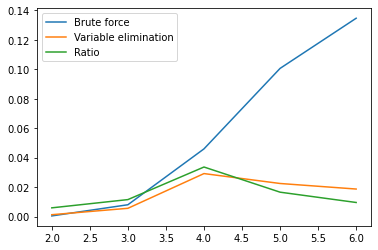

In [267]:
test_constant_bound(5, 2, 7, 2, 100, both=True, show_progress=True)

#### Solution
We can see that the time it takes for the brute force implementation to finish running grows rapidly with $N$, the number of values that each variable can take, noticeably diverging away from the variable elimination run time as early as $N = 4$.

#### Task
Run the following line of code to examine how the time it takes to run variable elimination increases with the number of values taken by each random variable. The Ratio in the output plot shows the ratio between the variable elimination run time and $N^K$, where $N$ is the number of values that each random variable can take on, and $K$ is the number of arrows going out from each node. What do you notice? Does this agree with what we derived in the lecture note?

Note: try running this line several times and messing around with the parameters (larger values are generally conducive to more theoretically correct results). The behavior of this function can depend on the Bayesian network structure being used (which is randomly generated with each run).

IntProgress(value=0)

IntProgress(value=0)

IntProgress(value=0)

IntProgress(value=0)

IntProgress(value=0)

IntProgress(value=0)

IntProgress(value=0)

IntProgress(value=0)

IntProgress(value=0)

IntProgress(value=0)

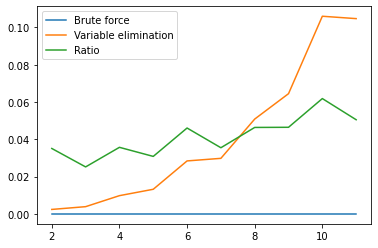

In [260]:
test_constant_bound(5, 2, 12, 2, 100, both=False, show_progress=True)

#### Solution
We can see that indeed, the variable elimination run time grows as the number of values taken on by each variable grows. The complexity described in the lecture note would imply that the ratio should be roughly constant, and by the look of this plot, it is. Your plots may tell a different story, because as we mentioned above, this output is somewhat subject to the whims of pseudorandomness. Now, if we used a Bayes' net with 100 nodes and ran thousands of trials, we would indeed see the output we expect based on lecture. For now, this will have to do.

The function `test_proportion` accepts similar parameters to `test`. The purpose of this method is to examine the asymptotic time complexity of variable elimination for a Bayesian network with some fixed fraction of the arrows present (i.e. each arrow is present with probability $\alpha \in (0,1)$ - this is not actually how it works as we have implemented it, but it's close enough). It will vary the number of values that each random variable in the network can take on, testing each number of values from `low` (inclusive) to `high` (exclusive). It uses a single Bayesian network structure (i.e. the same set of arrows) for all tests.

In [264]:
def test_proportion(num_vars, low, high, edges_param, trials_per, both=False, show_progress=False):
    l = []
    xvals = np.array(list(range(low, high)))
    struct = None
    for i in xvals:
        bft, vet, struct = test(num_vars, i, "Proportion", edges_param, 1, trials_per, both=both, show_progress=show_progress)
        l.append((bft, vet))
    
    bf_times = np.array([t[0] for t in l])
    ve_times = np.array([t[1] for t in l])
    line_bf, = plt.plot(xvals, bf_times, label="Brute force")
    line_ve, = plt.plot(xvals, ve_times, label="Variable elimination")
    log_approx = np.log(ve_times)
    ratio = log_approx / xvals
    ratio = ratio / np.mean(ratio) * np.mean(ve_times)
    line_rat, = plt.plot(xvals, ratio, label="Ratio")
    plt.legend(handles=[line_bf, line_ve, line_rat])
    
    plt.show()

#### Task

Run the following line of code to visualize how the running time of variable elimination increases with the number of values of each variable in the case that some constant proportion of the edges in the Bayesian network are present. In this case, the Ratio in the output plot is the ratio between the natural logarithm of the variable elimination run time and the number of values taken on by each variable. What do you notice? Does this agree with what we derived in the lecture note?

Note: try running this line several times and messing around with the parameters (larger values are generally conducive to more theoretically correct results). The behavior of this function can depend on the Bayesian network structure being used (which is randomly generated with each run).

IntProgress(value=0)

IntProgress(value=0)

IntProgress(value=0)

IntProgress(value=0)

IntProgress(value=0)

IntProgress(value=0)

IntProgress(value=0)

IntProgress(value=0)

IntProgress(value=0)

IntProgress(value=0)

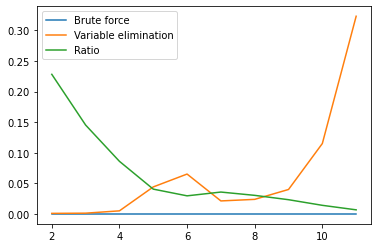

In [265]:
test_proportion(5, 2, 12, 0.4, 100, both=False, show_progress=True)

#### Solution
We can see that indeed, the run time of variable elimination starts to increase rapidly when the number of values gets sufficiently large. The ratio, rather strangely, does not appear linear as we would expect based on the lecture note, but rather looks vaguely like exponential decay. A fine explanation of this is the fact that the asymptotic complexity described in the lecture note is precisely that: _asymptotic_. In cases of fewer random variables (we're only using five here), the discreteness of the structure can limit our desired property from coming through.